Импроты и инициализация spark

In [1]:
from pyspark.conf import SparkConf
from pyspark.context import SparkContext
from pyspark.sql import SparkSession
import time
import pandas as pd
from pyspark.sql import SparkSession
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os

conf = SparkConf()
conf.setAppName('My spark')
conf.setMaster('local[*]').set('spark.executor.memory', '4G').set('spark.driver.memory', '8G').set('spark.driver.maxResultSize', '6G')

sc=SparkContext.getOrCreate(conf=conf)
spark= SparkSession.builder.getOrCreate()

print(conf.toDebugString())

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


spark.app.name=My spark
spark.master=local[*]
spark.executor.memory=4G
spark.driver.memory=8G
spark.driver.maxResultSize=6G


In [2]:
path_to_file = 'PAMAP2_Dataset\Optional\subject101.dat'

activity_val_name = {
    1  : 'lying',
    2  : 'sitting',
    3  : 'standing',
    4  : 'walking',
    5  : 'running',
    6  : 'cycling',
    7  : 'Nordic walking',
    9  : 'watching TV',
    10 : 'computer work',
    11 : 'car driving',
    12 : 'ascending stairs',
    13 : 'descending stairs',
    16 : 'vacuum cleaning',
    17 : 'ironing',
    18 : 'folding laundry',
    19 : 'house cleaning',
    20 : 'playing soccer',
    24 : 'rope jumping',
    0  : 'other (transient activities)',
}

activity_name_val = {
    'lying' : 1 ,
    'sitting' : 2 ,
    'standing' : 3 ,
    'walking' : 4 ,
    'running' : 5 ,
    'cycling' : 6 ,
    'Nordic walking' : 7 ,
    'watching TV' : 9 ,
    'computer work' : 10,
    'car driving' : 11,
    'ascending stairs' : 12,
    'descending stairs' : 13,
    'vacuum cleaning' : 16,
    'ironing' : 17,
    'folding laundry' : 18,
    'house cleaning' : 19,
    'playing soccer' : 20,
    'rope jumping' : 24,
    'other (transient activities)' : 0 ,
}

col_names = ['Time_stamp', 'Activity_ID', 'Heart_Rate', 
              # Hand
             'Hand_temperature', 'Hand_3D_Acceleration_1', 'Hand_3D_Acceleration_2', 'Hand_3D_Acceleration_3',
             'Hand_3D_Acceleration_4', 'Hand_3D_Acceleration_5', 'Hand_3D_Acceleration_6', 'Hand_3D_Gyroscope_1',
             'Hand_3D_Gyroscope_2', 'Hand_3D_Gyroscope_3', 'Hand_3D_Magnetometer_1', 'Hand_3D_Magnetometer_2', 
             'Hand_3D_Magnetometer_3', 'Hand_3D_Orientation_1', 'Hand_3D_Orientation_2', 'Hand_3D_Orientation_3',
             'Hand_3D_Orientation_4',
             # Chest
             'Chest_temperature', 'Chest_3D_Acceleration_1', 'Chest_3D_Acceleration_2', 'Chest_3D_Acceleration_3',
             'Chest_3D_Acceleration_4', 'Chest_3D_Acceleration_5', 'Chest_3D_Acceleration_6', 'Chest_3D_Gyroscope_1',
             'Chest_3D_Gyroscope_2', 'Chest_3D_Gyroscope_3', 'Chest_3D_Magnetometer_1', 'Chest_3D_Magnetometer_2', 
             'Chest_3D_Magnetometer_3', 'Chest_3D_Orientation_1', 'Chest_3D_Orientation_2', 'Chest_3D_Orientation_3',
             'Chest_3D_Orientation_4',
             # Ankle
             'Ankle_temperature', 'Ankle_3D_Acceleration_1', 'Ankle_3D_Acceleration_2', 'Ankle_3D_Acceleration_3',
             'Ankle_3D_Acceleration_4', 'Ankle_3D_Acceleration_5', 'Ankle_3D_Acceleration_6', 'Ankle_3D_Gyroscope_1',
             'Ankle_3D_Gyroscope_2', 'Ankle_3D_Gyroscope_3', 'Ankle_3D_Magnetometer_1', 'Ankle_3D_Magnetometer_2', 
             'Ankle_3D_Magnetometer_3', 'Ankle_3D_Orientation_1','Ankle_3D_Orientation_2', 'Ankle_3D_Orientation_3',
             'Ankle_3D_Orientation_4']

from pyspark.sql.types import FloatType
from pyspark.sql.types import IntegerType
def load_df(path):
    
    df = spark.read.option('sep', ' ').csv(path)
    for i in range(len(df.columns)):
        df = df.withColumnRenamed('_c' + str(i), col_names[i])

    # Replace string on float
    for col_name in df.columns:
        df = df.withColumn(col_name, df[col_name].cast(FloatType()))
    df = df.withColumn('Activity_ID', df['Activity_ID'].cast(IntegerType()))
    
    # According to description, this values were measured incorrect
    df = df.drop(*['Ankle_3D_Orientation_1','Ankle_3D_Orientation_2', 'Ankle_3D_Orientation_3', 'Ankle_3D_Orientation_4'])
    df = df.drop(*['Chest_3D_Orientation_1', 'Chest_3D_Orientation_2', 'Chest_3D_Orientation_3', 'Chest_3D_Orientation_4'])
    df = df.drop(*['Hand_3D_Orientation_1', 'Hand_3D_Orientation_2', 'Hand_3D_Orientation_3', 'Hand_3D_Orientation_4'])

    
    return df

def shape(df):
    print((df.count(), len(df.columns)))

def unique(df, column):
     df.select(column).distinct().sort(column).show()

def getUnique(df, column, sort=False):
    if sort == True:
        return df.select(column).distinct().sort(column)
    else:
        return df.select(column).distinct()

def getList(df, column, limit=0):
    selected_df = df.select(column)
    if limit != 0:
        selected_df = selected_df.limit(limit)
    
    return [float(row[column]) for row in selected_df.collect()]

def get_available_activities(df):
    activities = getList(getUnique(df, 'Activity_ID', True), 'Activity_ID')
    for i in range(len(activities)):
        activities[i] = int(activities[i])

    res = []
    for act in activities:
        res.append(activity_val_name[act])
    return res

def print_available_activities(df, subject_id):
    activities = getList(getUnique(df, 'Activity_ID', True), 'Activity_ID')
    for i in range(len(activities)):
        activities[i] = int(activities[i])

    print('Activities ' + str(subject_id) + ':')
    for act in activities:
        print(activity_val_name[act])

def print_sensor_graphs(df, activity_name, sensor_names, data_limit=0, figsize=(10, 10)):
    df = df.filter(df.Activity_ID == activity_name_val[activity_name])
 
    if data_limit != 0:
        df = df.limit(data_limit)

    df = df.sort(df.Time_stamp)
    x = df.select(df.Time_stamp).collect()
    
    for sensor_name in sensor_names:
        fig, ax = plt.subplots(figsize=figsize)
        ax.plot(x, getList(df, sensor_name))
        ax.set_ylabel(sensor_name)
        ax.set_xlabel('Time')
        ax.set_title(activity_name)
        plt.grid(True)

def getValue(df, column, row):
    return df.select(column).collect()[row].asDict()[column]

def intensityStrToInt(val_str):
    return ['minimum','low','medium','high'].index(val_str)

def getStrList(df, column, limit=0):
    selected_df = df.select(column)
    if limit != 0:
        selected_df = selected_df.limit(limit)
    
    return [row[column] for row in selected_df.collect()]

def count_not_null(c, nan_as_null=False):
    pred = col(c).isNotNull() & (~isnan(c) if nan_as_null else lit(True))
    return sum(pred.cast("integer")).alias(c)
# df.agg(*[count_not_null(c) for c in df.columns]).show()
    
def getValue(df, column, row):
    return df.select(column).collect()[row].asDict()[column]

def get_available_activities(df):
    activities = getList(getUnique(df, 'Activity_ID', True), 'Activity_ID')
    for i in range(len(activities)):
        activities[i] = int(activities[i])

    res = []
    for act in activities:
        res.append(activity_val_name[act])
    return res


df_101 = load_df('PAMAP2_Dataset\Protocol\subject101.dat')
df_102 = load_df('PAMAP2_Dataset\Protocol\subject102.dat')
df_103 = load_df('PAMAP2_Dataset\Protocol\subject103.dat')
df_104 = load_df('PAMAP2_Dataset\Protocol\subject104.dat')
df_105 = load_df('PAMAP2_Dataset\Protocol\subject105.dat')
df_106 = load_df('PAMAP2_Dataset\Protocol\subject106.dat')
df_107 = load_df('PAMAP2_Dataset\Protocol\subject107.dat')
df_108 = load_df('PAMAP2_Dataset\Protocol\subject108.dat')
df_109 = load_df('PAMAP2_Dataset\Protocol\subject109.dat')


In [25]:
def heart_rate_plot(df):
    fig, ax = plt.subplots(figsize=(20, 7))
    for i in activity_name_val:
        df_act = df.filter(df.Activity_ID == activity_name_val[i])
        df_act = df_act.sort(df_act.Time_stamp)
        x = df_act.select(df_act.Time_stamp).collect()
        ax.scatter(x, getList(df_act, 'Heart_Rate'), label=i)

    lgd = plt.legend(loc='best',fontsize = 9)
    ax.set_ylabel('Heart_Rate')
    ax.set_xlabel('Time')
    ax.set_title('Heart_Rate for different activities')
    plt.grid(True)
    
def hr_sensors_plot(df, activity_name, sensor_names, data_limit=0, figsize=(10, 10)):
    df = df.filter(df.Activity_ID == activity_name_val[activity_name])
 
    if data_limit != 0:
        df = df.limit(data_limit)

    df = df.sort(df.Heart_Rate)
    x = df.select(df.Heart_Rate).collect()
    
    fig, ax = plt.subplots(figsize=figsize)
    for sensor_name in sensor_names:
        ax.scatter(x, getList(df, sensor_name), label=sensor_name)
    lgd = plt.legend(loc='best',fontsize = 9)
    ax.set_ylabel('Sensors')
    ax.set_xlabel('Heart rate')
    ax.set_title(activity_name)
    plt.grid(True)

In [30]:
shape(df_102)
unique(df_102, 'Activity_ID')
df_102.limit(10).toPandas().head()

(447000, 42)
+-----------+
|Activity_ID|
+-----------+
|          0|
|          1|
|          2|
|          3|
|          4|
|          5|
|          6|
|          7|
|         12|
|         13|
|         16|
|         17|
|         24|
+-----------+



,Time_stamp,Activity_ID,Heart_Rate,Hand_temperature,Hand_3D_Acceleration_1,Hand_3D_Acceleration_2,Hand_3D_Acceleration_3,Hand_3D_Acceleration_4,Hand_3D_Acceleration_5,Hand_3D_Acceleration_6,...,Ankle_3D_Acceleration_3,Ankle_3D_Acceleration_4,Ankle_3D_Acceleration_5,Ankle_3D_Acceleration_6,Ankle_3D_Gyroscope_1,Ankle_3D_Gyroscope_2,Ankle_3D_Gyroscope_3,Ankle_3D_Magnetometer_1,Ankle_3D_Magnetometer_2,Ankle_3D_Magnetometer_3
0,5.64,0,NaN,33.0,2.79143,7.55389,-7.06374,2.87553,7.88823,-6.76139,...,-1.64674,9.73055,-0.846832,-1.29665,-0.027148,-0.031190,-0.040897,-47.769501,-2.58701,59.848099
1,5.65,0,NaN,33.0,2.86086,7.43814,-7.21626,2.84248,7.63164,-6.85140,...,-1.80115,9.73049,-0.816601,-1.31189,0.012803,-0.036384,-0.014845,-47.762402,-2.81438,60.340698
2,5.66,0,100.0,33.0,2.80997,7.09430,-7.52376,2.79373,7.43545,-7.07744,...,-1.76432,9.73032,-0.756157,-1.35749,-0.001695,-0.034529,-0.040074,-47.539299,-2.38909,60.962299
3,5.67,0,NaN,33.0,2.77138,6.98077,-7.52396,2.80627,7.29929,-7.24326,...,-1.76223,9.70051,-0.816589,-1.29659,0.055437,-0.011560,0.015434,-47.424599,-2.72082,60.710300
4,5.68,0,NaN,33.0,2.76710,7.13119,-7.67848,2.78766,7.11797,-7.48445,...,-2.03407,9.73043,-0.816620,-1.32702,0.017184,-0.034663,0.007239,-47.541199,-2.60153,60.341202


Activities 102:
other (transient activities)
lying
sitting
standing
walking
running
cycling
Nordic walking
ascending stairs
descending stairs
vacuum cleaning
ironing
rope jumping


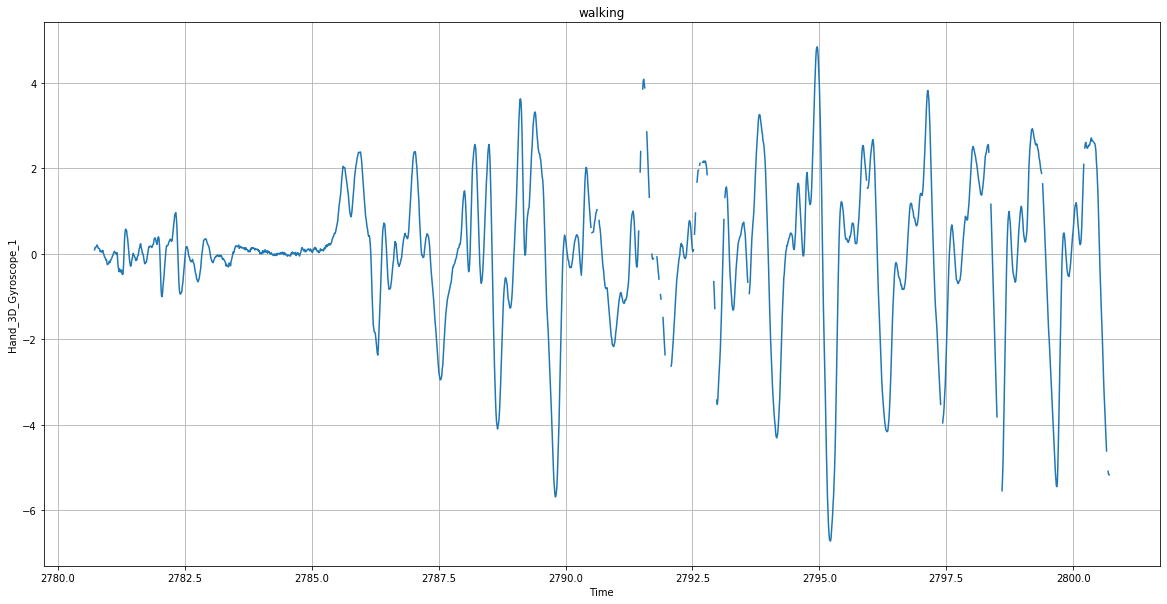

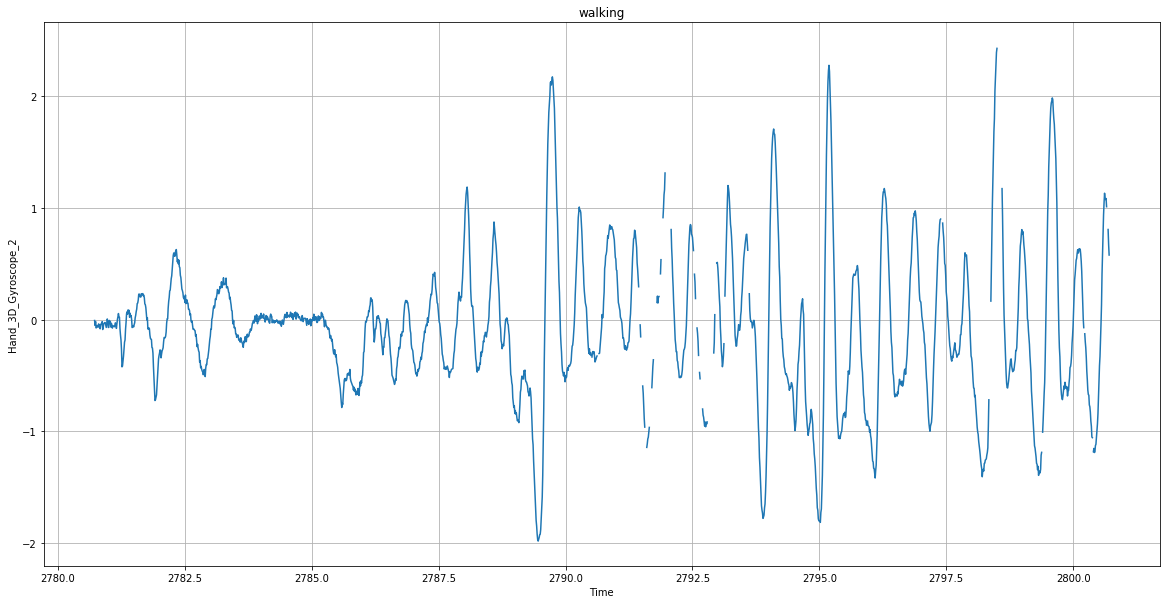

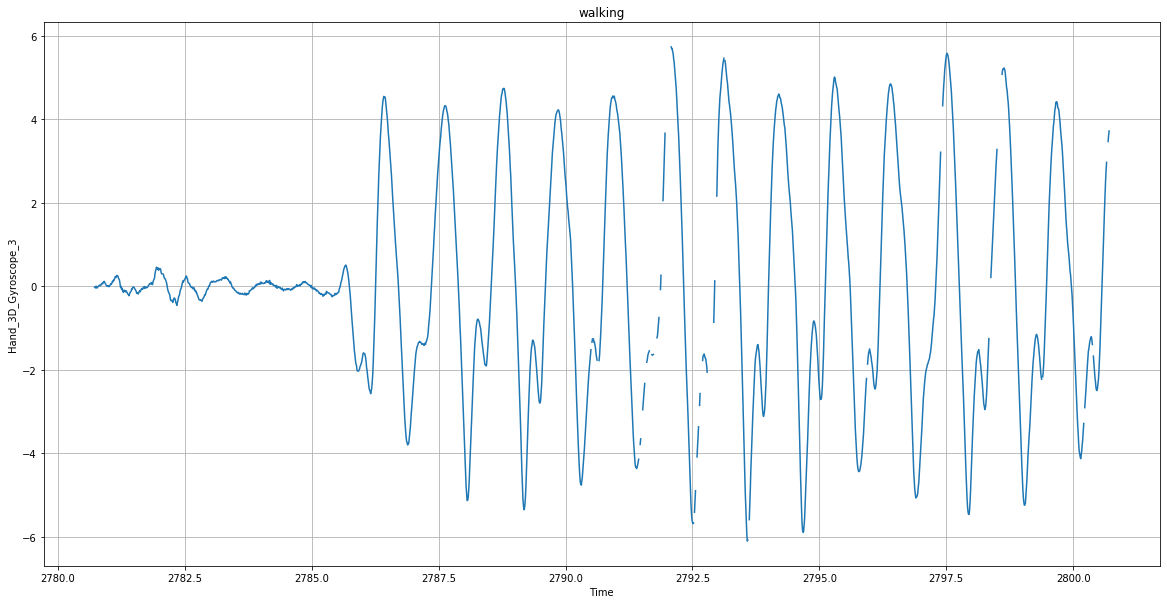

In [4]:
print_available_activities(df_102, 102)
print_sensor_graphs(df_102, 'walking', ['Hand_3D_Gyroscope_1', 'Hand_3D_Gyroscope_2', 'Hand_3D_Gyroscope_3'], 2000, (20, 10))

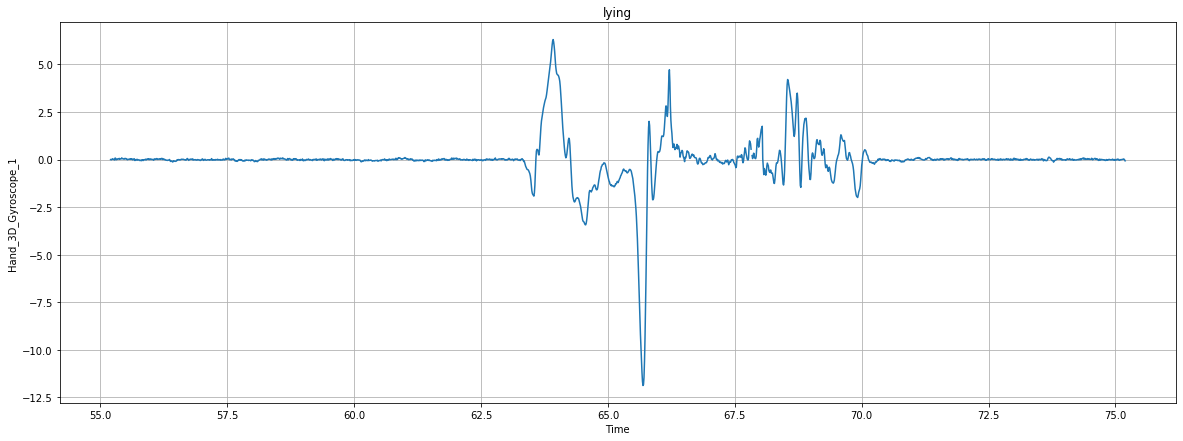

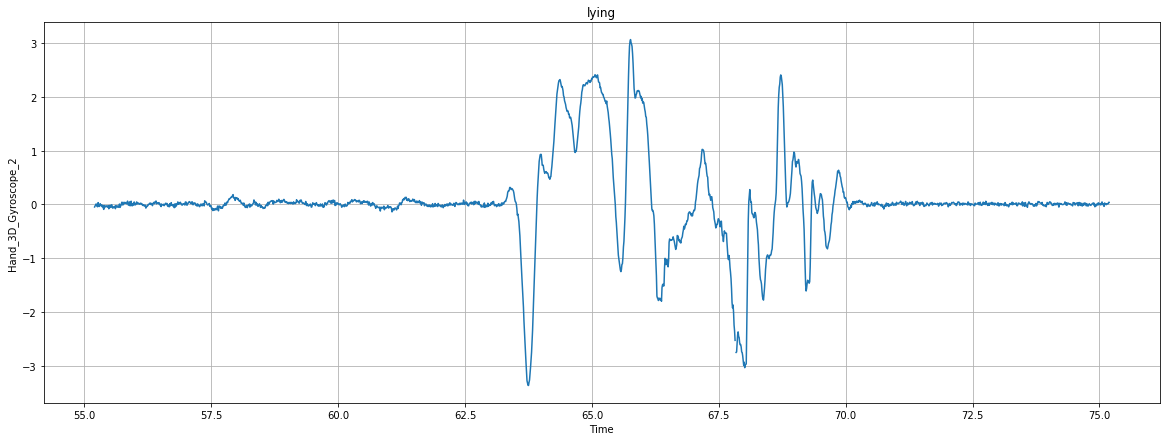

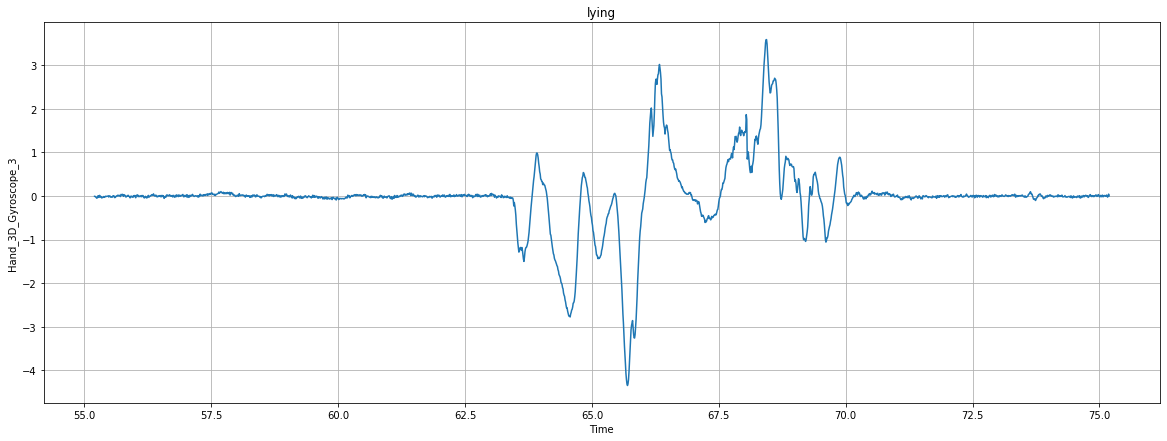

In [5]:
print_sensor_graphs(df_102, 'lying', ['Hand_3D_Gyroscope_1', 'Hand_3D_Gyroscope_2', 'Hand_3D_Gyroscope_3'], 2000, (20, 7))

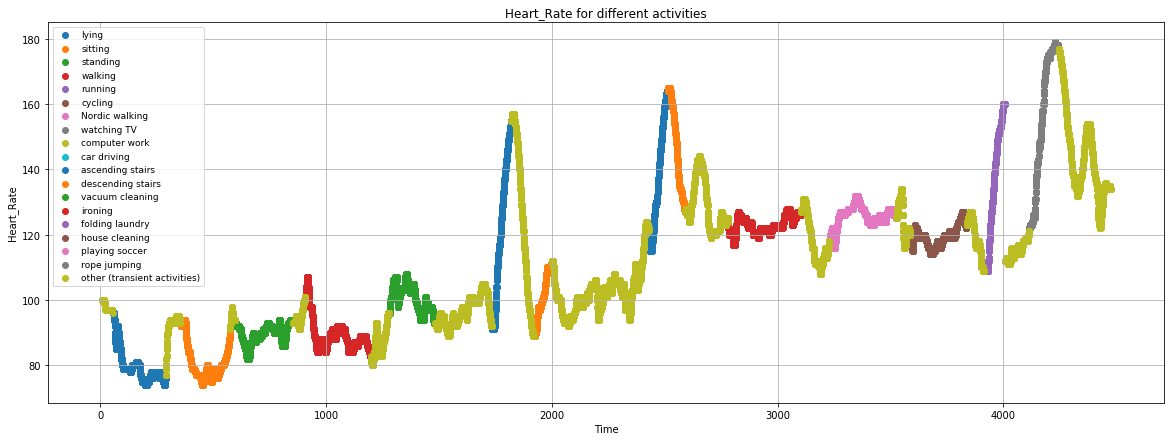

In [26]:
heart_rate_plot(df_102)

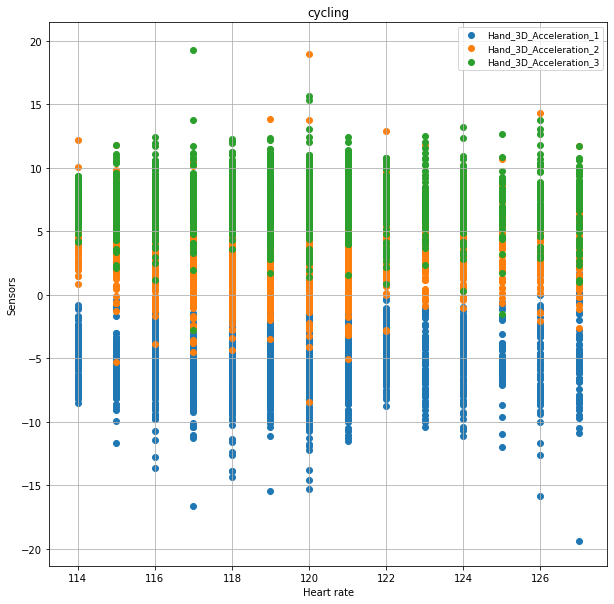

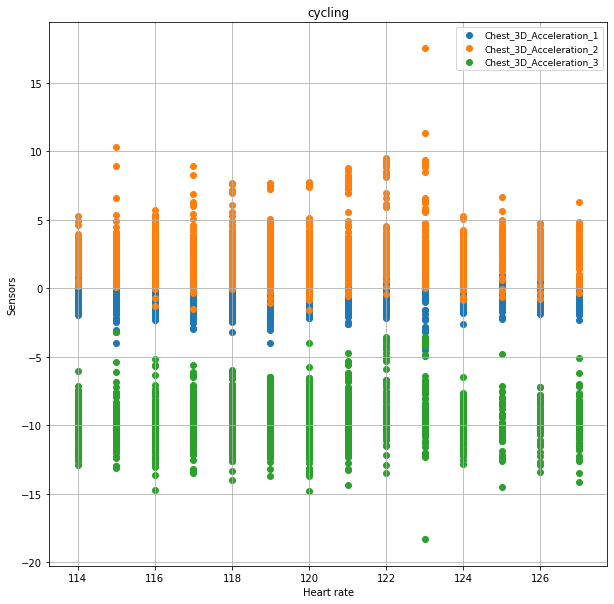

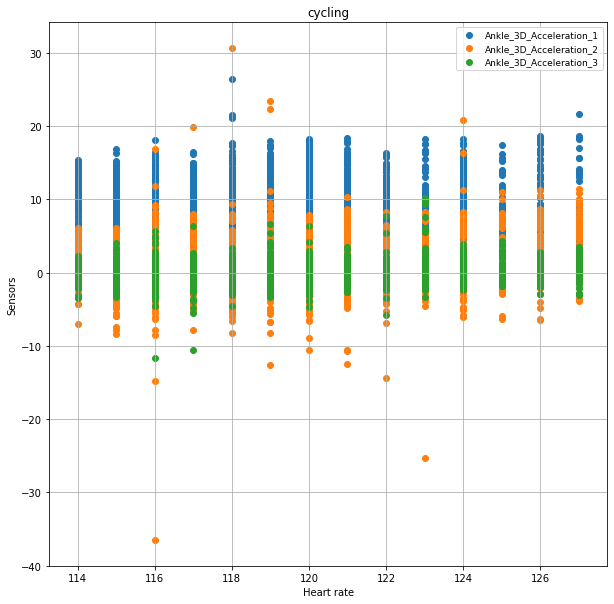

In [27]:
hr_sensors_plot(df_102, 'cycling', ['Hand_3D_Acceleration_1', 'Hand_3D_Acceleration_2', 'Hand_3D_Acceleration_3'])
hr_sensors_plot(df_102, 'cycling', ['Chest_3D_Acceleration_1', 'Chest_3D_Acceleration_2', 'Chest_3D_Acceleration_3'])
hr_sensors_plot(df_102, 'cycling', ['Ankle_3D_Acceleration_1', 'Ankle_3D_Acceleration_2', 'Ankle_3D_Acceleration_3'])

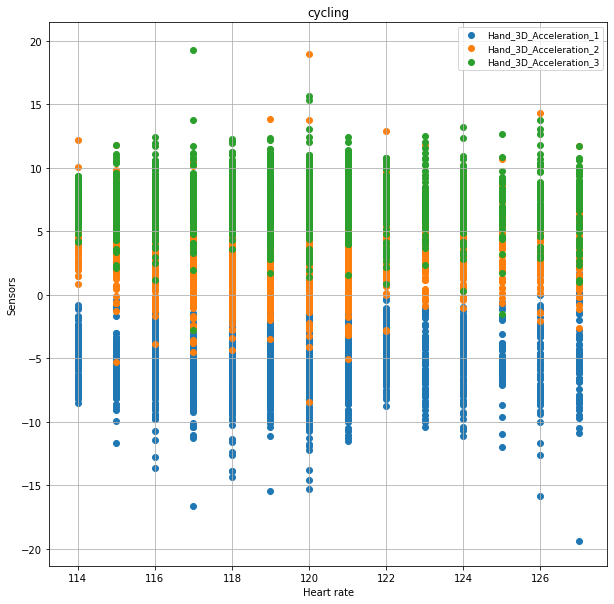

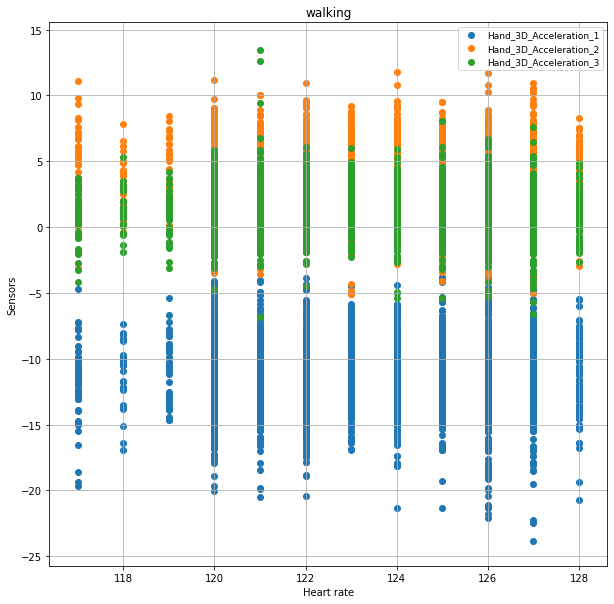

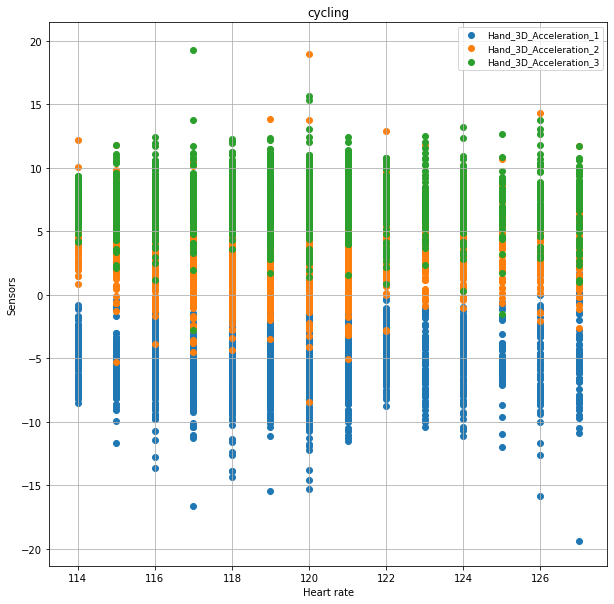

In [28]:
hr_sensors_plot(df_102, 'cycling', ['Hand_3D_Acceleration_1', 'Hand_3D_Acceleration_2', 'Hand_3D_Acceleration_3'])
hr_sensors_plot(df_102, 'walking', ['Hand_3D_Acceleration_1', 'Hand_3D_Acceleration_2', 'Hand_3D_Acceleration_3'])
hr_sensors_plot(df_102, 'cycling', ['Hand_3D_Acceleration_1', 'Hand_3D_Acceleration_2', 'Hand_3D_Acceleration_3'])

In [6]:
from pyspark.sql.functions import element_at, col

df = df_102

# df.filter(df.Activity_ID == ).limit(5).toPandas().head()

print(df.filter(df.Activity_ID == 4).select('Time_stamp').collect()[0][0])
print(df.filter(df.Activity_ID == 4).select('Time_stamp').collect()[-1][0])

# df.filter(df.Activity_ID == 'walking').select(element_at(col('Time_stamp'), -1)).toPandas().head()

2780.719970703125
3106.0400390625


In [7]:
df = df_102
df.select(df.Time_stamp > 20.0).limit(10).toPandas().head()

df.filter(df.Activity_ID == activity_name_val['ascending stairs']).limit(5).toPandas().head()

for activity in get_available_activities(df):
    time_stamps = df.filter(df.Activity_ID == activity_name_val[activity]).select('Time_stamp').collect()
    print('Time stamp', time_stamps[-1][0] - 40.0 - time_stamps[0][0])

Time stamp 4429.989882946014
Time stamp 194.28998947143555
Time stamp 183.43997192382812
Time stamp 215.75
Time stamp 285.320068359375
Time stamp 52.3701171875
Time stamp 211.070068359375
Time stamp 257.380126953125
Time stamp 741.0999755859375
Time stamp 628.239990234375
Time stamp 166.8199462890625
Time stamp 248.78997802734375
Time stamp 92.6103515625


Activities 102:
lying
sitting
standing
walking
running
cycling
Nordic walking
ascending stairs
descending stairs
vacuum cleaning
ironing
rope jumping
Before:  0


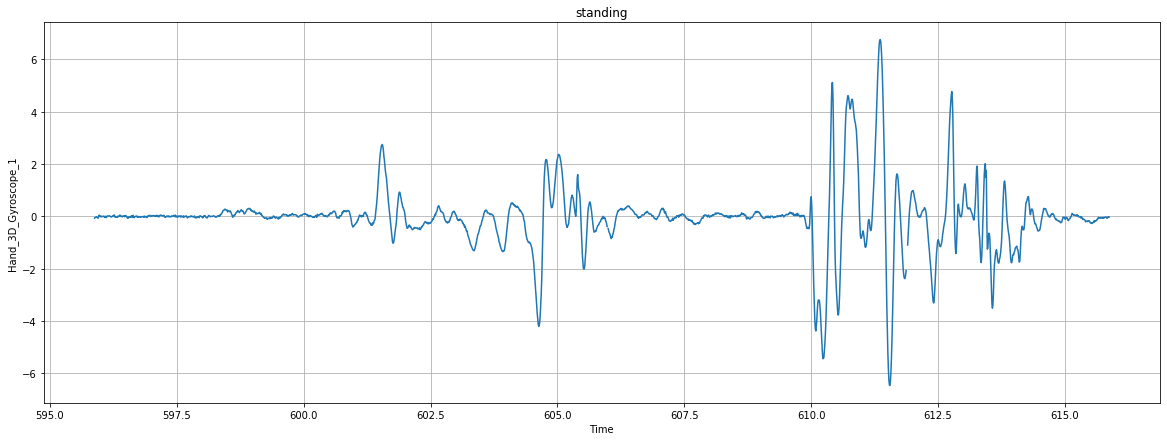

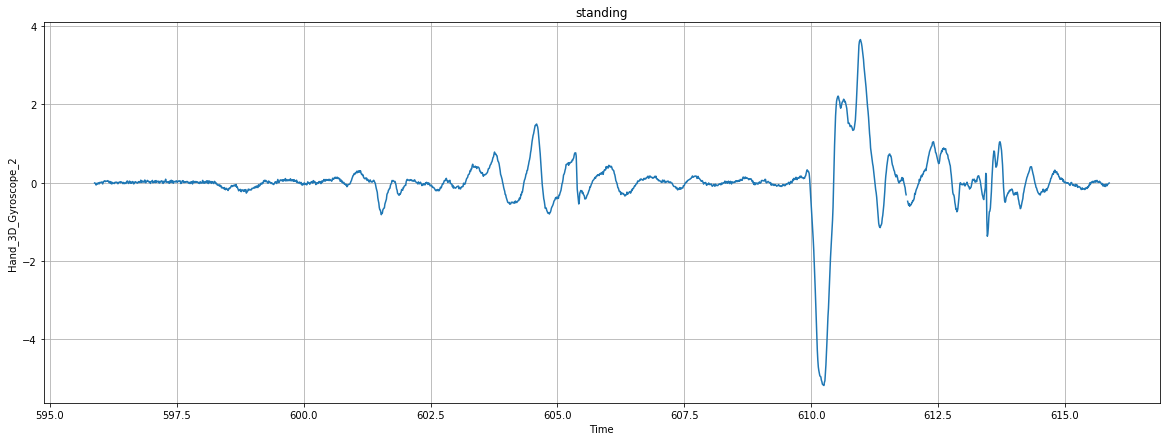

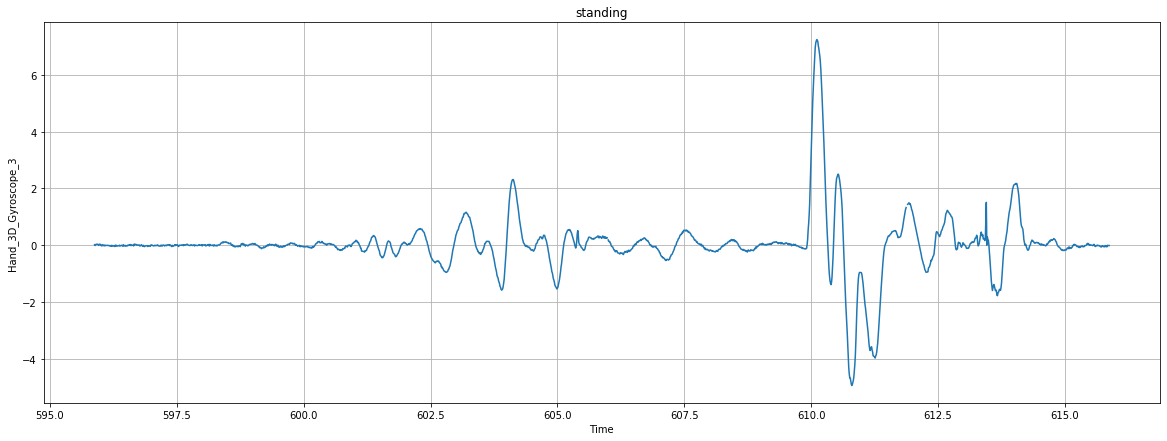

In [8]:
from pyspark.sql.functions import element_at, col
from pyspark.sql import functions as F

df = df_102.filter(df_102.Activity_ID != activity_name_val['other (transient activities)'])

print_available_activities(df, 102)

print('Before: ', df.where(col("Time_stamp").isNull()).count())
'''
for activity in ['walking', 'running', 'cycling']:    
    time_stamps = df.filter(df.Activity_ID == activity_name_val[activity]).select('Time_stamp').collect()

    print('Time stamp', time_stamps[0][0]  + 20.0, time_stamps[-1][0] - 20.0)
    df = df.withColumn('Time_stamp', F.when(\
                                            (df.Time_stamp.isNull() == False) &\
                                            (df.Activity_ID == activity_name_val[activity]) &\
                                            ((df.Time_stamp > time_stamps[0][0]) &\
                                            (df.Time_stamp < time_stamps[0][0]  + 20.0) |\
                                            (df.Time_stamp > time_stamps[-1][0] - 20.0) &\
                                            (df.Time_stamp < time_stamps[-1][0])),\
                                           None).otherwise(df.Time_stamp))
    
    print('In cycle ', df.where(col("Time_stamp").isNull()).count())
'''
    

    
    
#print('After: ', df.where(col("Time_stamp").isNull()).count())
print_sensor_graphs(df, 'standing', ['Hand_3D_Gyroscope_1', 'Hand_3D_Gyroscope_2', 'Hand_3D_Gyroscope_3'], 2000, (20, 7))






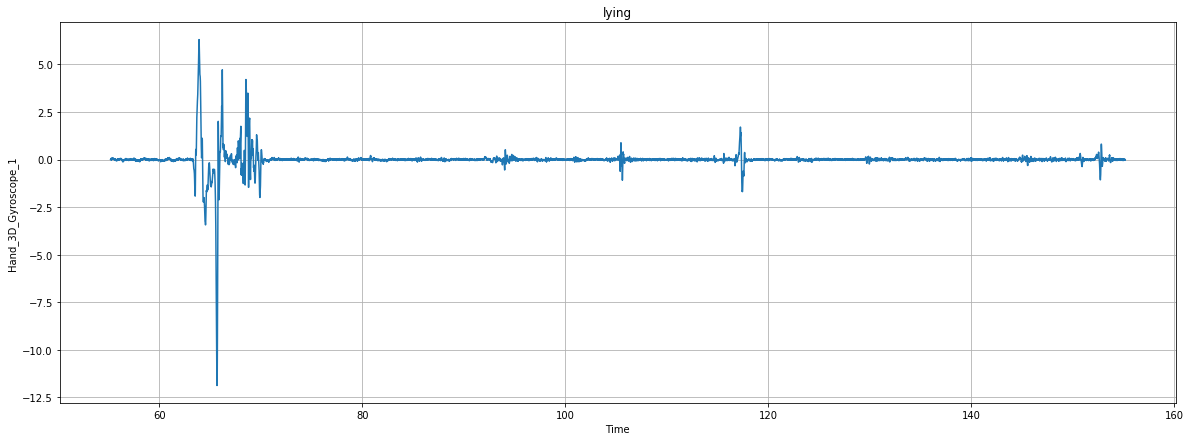

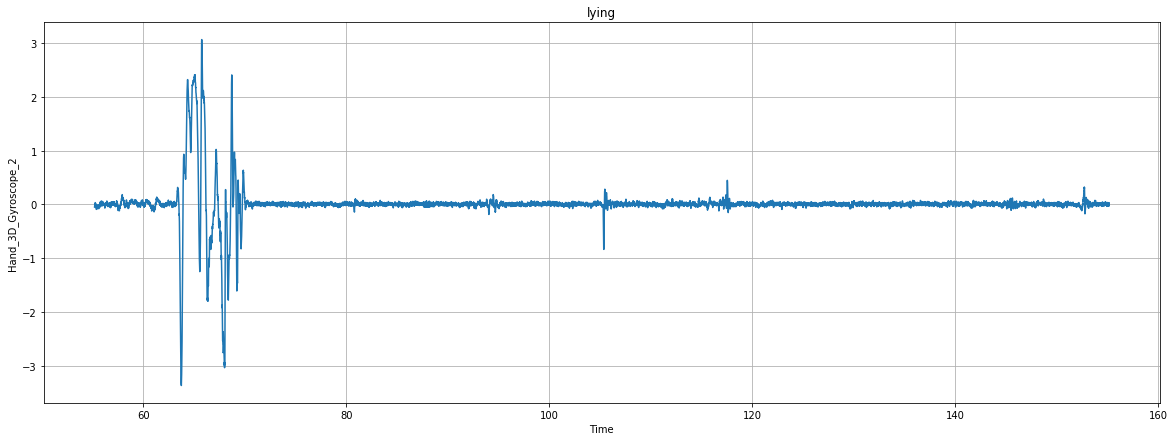

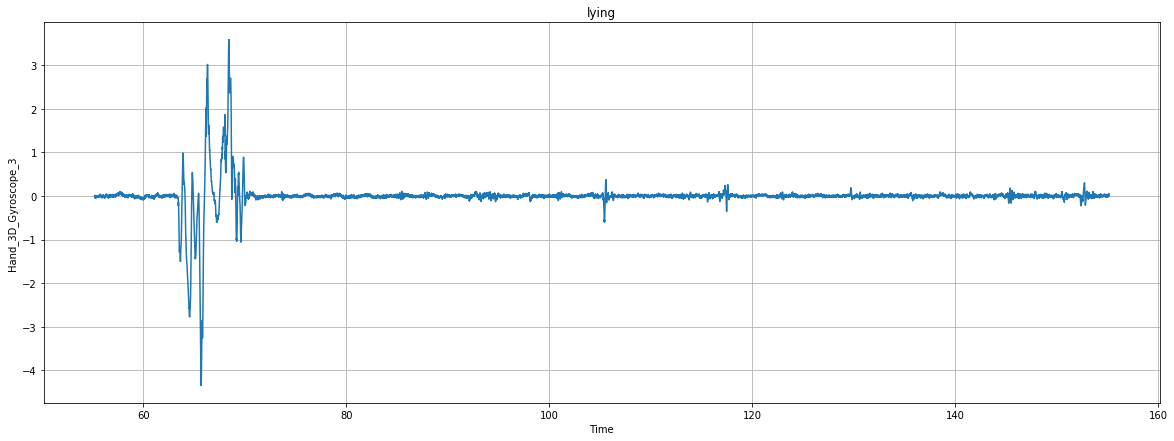

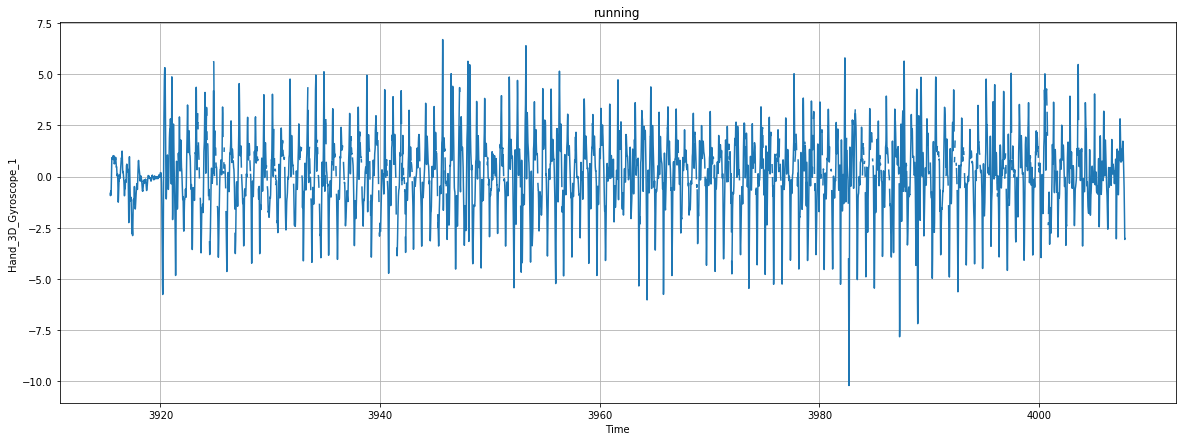

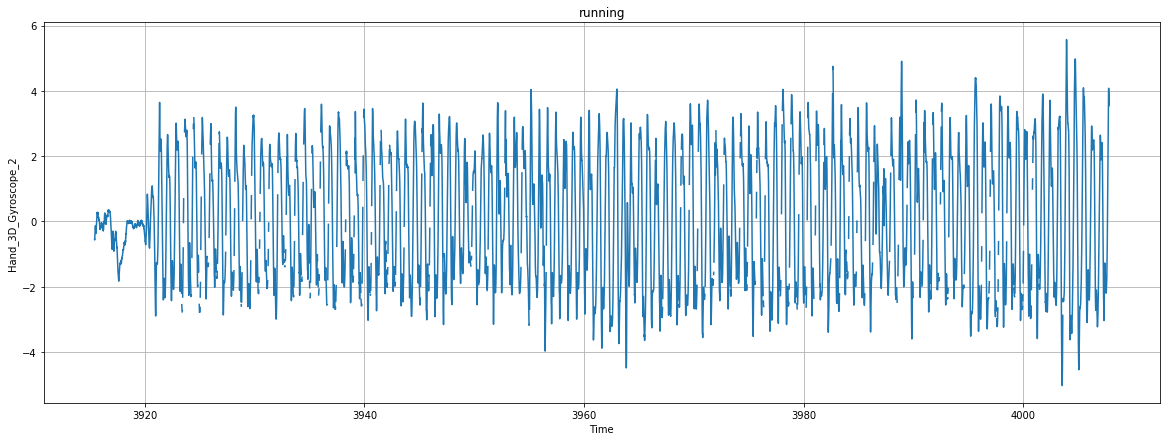

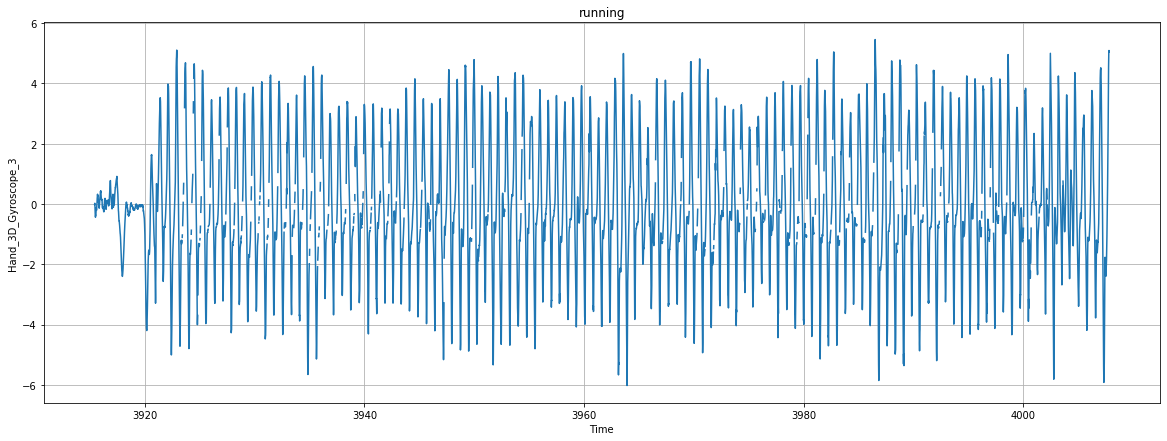

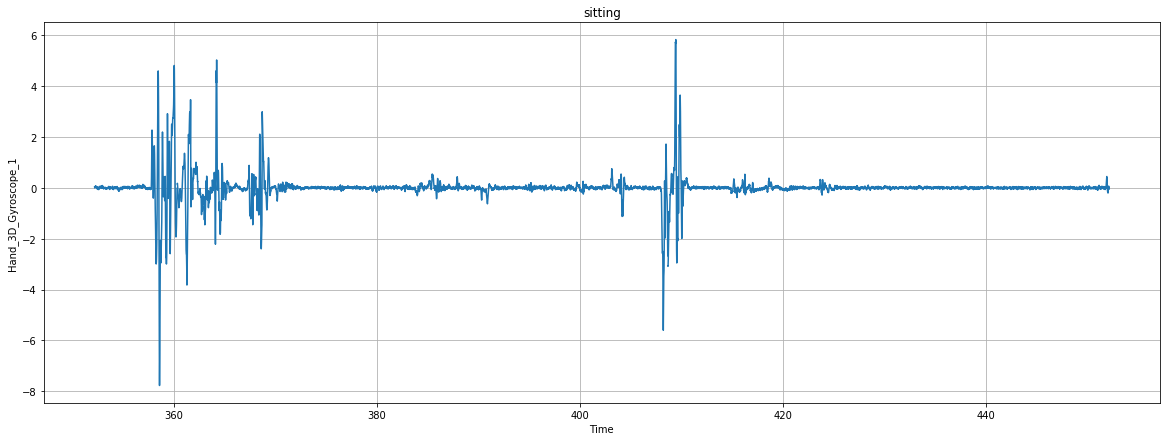

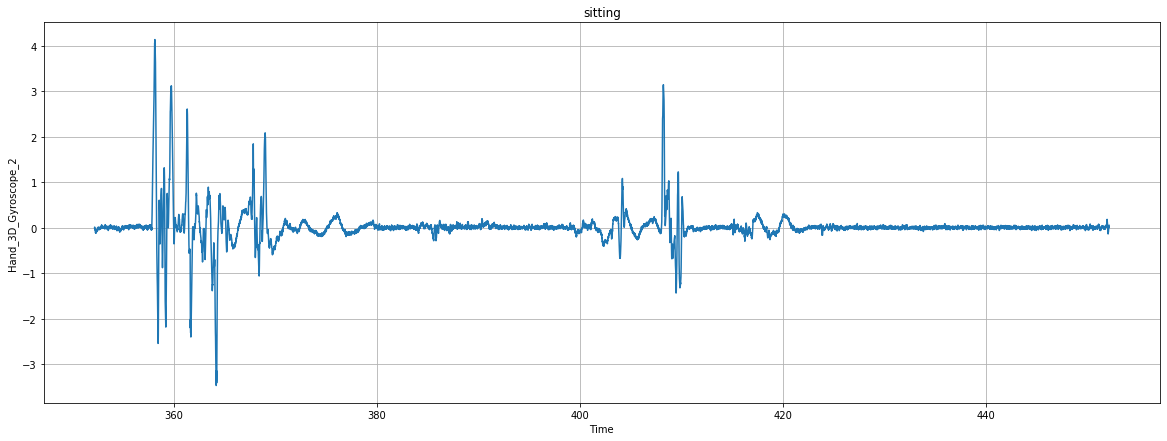

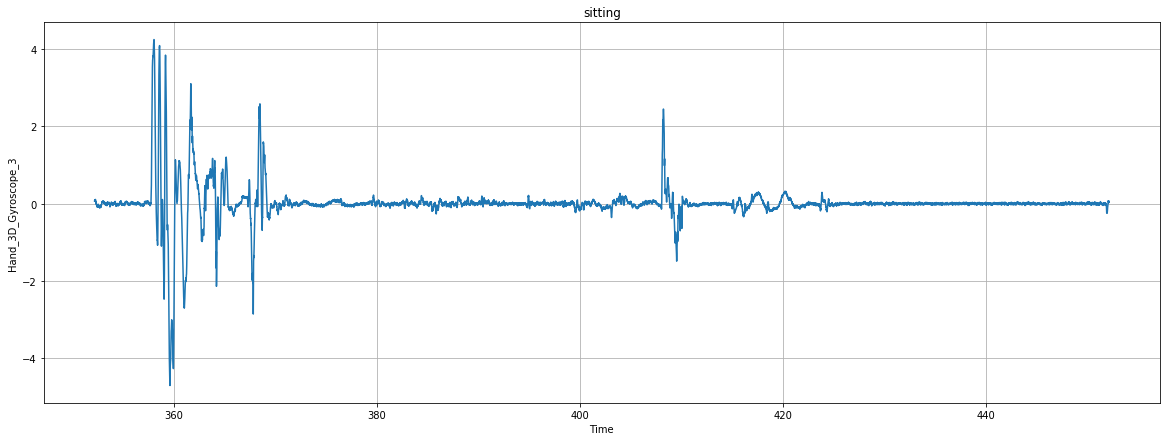

In [9]:

print_sensor_graphs(df, 'lying', ['Hand_3D_Gyroscope_1', 'Hand_3D_Gyroscope_2', 'Hand_3D_Gyroscope_3'],   10000, (20, 7))
print_sensor_graphs(df, 'running', ['Hand_3D_Gyroscope_1', 'Hand_3D_Gyroscope_2', 'Hand_3D_Gyroscope_3'], 10000, (20, 7))
print_sensor_graphs(df, 'sitting', ['Hand_3D_Gyroscope_1', 'Hand_3D_Gyroscope_2', 'Hand_3D_Gyroscope_3'], 10000, (20, 7))


In [10]:
from pyspark.sql import functions as F
from pyspark.sql.functions import lit
from pyspark.sql import Window
from pyspark.sql.functions import last
import sys

from pyspark.sql.functions import col, count, isnan, lit, sum
from pyspark.sql.window import Window as W
from pyspark.sql import functions as F

df.printSchema()

df = df.withColumn('intensity', lit(0))

columns = df.columns
for column in columns:
    df = df.withColumn(column,F.when(F.isnan(F.col(column)),None).otherwise(F.col(column)))


window = Window.partitionBy('Activity_ID')\
               .orderBy('Time_stamp')\
               .rowsBetween(-sys.maxsize, 0)

# define the forward-filled column
filled_column = last(df['Heart_Rate'], ignorenulls=True).over(window)

# do the fill
df = df.withColumn('Heart_Rate', filled_column)
df = df.where(col('Heart_Rate').isNotNull())

df = df.filter(df['Activity_ID'] != 0)

df.orderBy('Time_stamp', 'Activity_ID').limit(4).toPandas().head()

root
 |-- Time_stamp: float (nullable = true)
 |-- Activity_ID: integer (nullable = true)
 |-- Heart_Rate: float (nullable = true)
 |-- Hand_temperature: float (nullable = true)
 |-- Hand_3D_Acceleration_1: float (nullable = true)
 |-- Hand_3D_Acceleration_2: float (nullable = true)
 |-- Hand_3D_Acceleration_3: float (nullable = true)
 |-- Hand_3D_Acceleration_4: float (nullable = true)
 |-- Hand_3D_Acceleration_5: float (nullable = true)
 |-- Hand_3D_Acceleration_6: float (nullable = true)
 |-- Hand_3D_Gyroscope_1: float (nullable = true)
 |-- Hand_3D_Gyroscope_2: float (nullable = true)
 |-- Hand_3D_Gyroscope_3: float (nullable = true)
 |-- Hand_3D_Magnetometer_1: float (nullable = true)
 |-- Hand_3D_Magnetometer_2: float (nullable = true)
 |-- Hand_3D_Magnetometer_3: float (nullable = true)
 |-- Chest_temperature: float (nullable = true)
 |-- Chest_3D_Acceleration_1: float (nullable = true)
 |-- Chest_3D_Acceleration_2: float (nullable = true)
 |-- Chest_3D_Acceleration_3: float (nu

,Time_stamp,Activity_ID,Heart_Rate,Hand_temperature,Hand_3D_Acceleration_1,Hand_3D_Acceleration_2,Hand_3D_Acceleration_3,Hand_3D_Acceleration_4,Hand_3D_Acceleration_5,Hand_3D_Acceleration_6,...,Ankle_3D_Acceleration_4,Ankle_3D_Acceleration_5,Ankle_3D_Acceleration_6,Ankle_3D_Gyroscope_1,Ankle_3D_Gyroscope_2,Ankle_3D_Gyroscope_3,Ankle_3D_Magnetometer_1,Ankle_3D_Magnetometer_2,Ankle_3D_Magnetometer_3,intensity
0,55.250000,1,96.0,33.4375,-6.85310,6.42653,2.60988,-6.71861,6.44101,2.73487,...,9.68424,-1.24042,-1.56758,0.016081,-0.018830,0.038106,-46.457901,0.548047,61.232300,0
1,55.259998,1,96.0,33.4375,-6.80969,6.46551,2.76434,-6.74913,6.38084,2.75013,...,9.62410,-1.21021,-1.58249,0.035604,-0.021145,0.038924,-46.679699,0.659664,61.730499,0
2,55.270000,1,96.0,33.4375,-6.84641,6.42820,2.80241,-6.71924,6.38060,2.71990,...,9.63931,-1.21015,-1.53716,0.001366,-0.025663,0.034065,-47.246300,0.689326,60.992699,0
3,55.279999,1,96.0,33.4375,-6.81531,6.42623,2.61044,-6.71911,6.38061,2.73500,...,9.66915,-1.25557,-1.58258,0.069962,-0.011881,0.032799,-47.022499,0.574392,60.742100,0


In [11]:
unique(df, 'Activity_ID')
shape(df)

+-----------+
|Activity_ID|
+-----------+
|          1|
|          2|
|          3|
|          4|
|          5|
|          6|
|          7|
|         12|
|         13|
|         16|
|         17|
|         24|
+-----------+

(263294, 43)


In [12]:
target_labels = ['minimum','low','medium','high']
conversion_dict = {'minimum':[1,2,3,9,10,11,18],
                   'low': [17,13,19],
                   'medium': [4,12,16],
                   'high':[5,6,7,20,24]}

for tl in target_labels:
    lact = conversion_dict[tl]
    for iactivity in lact:
        df = df.withColumn('intensity', F.when(F.col('Activity_ID') == iactivity, tl).otherwise(F.col("intensity")))


unique(df, 'intensity')
unique(df, 'Activity_ID')
shape(df)
df.limit(5).toPandas().head()

+---------+
|intensity|
+---------+
|     high|
|      low|
|   medium|
|  minimum|
+---------+

+-----------+
|Activity_ID|
+-----------+
|          1|
|          2|
|          3|
|          4|
|          5|
|          6|
|          7|
|         12|
|         13|
|         16|
|         17|
|         24|
+-----------+

(263294, 43)


,Time_stamp,Activity_ID,Heart_Rate,Hand_temperature,Hand_3D_Acceleration_1,Hand_3D_Acceleration_2,Hand_3D_Acceleration_3,Hand_3D_Acceleration_4,Hand_3D_Acceleration_5,Hand_3D_Acceleration_6,...,Ankle_3D_Acceleration_4,Ankle_3D_Acceleration_5,Ankle_3D_Acceleration_6,Ankle_3D_Gyroscope_1,Ankle_3D_Gyroscope_2,Ankle_3D_Gyroscope_3,Ankle_3D_Magnetometer_1,Ankle_3D_Magnetometer_2,Ankle_3D_Magnetometer_3,intensity
0,1734.170044,12,92.0,34.375,-8.77245,2.57064,2.51716,-8.58822,2.76955,2.74483,...,9.74553,-0.998079,-1.29625,0.005426,-0.003315,0.011441,-12.9911,7.16166,-3.08824,medium
1,1734.180054,12,92.0,34.375,-8.66683,2.60570,2.28770,-8.55833,2.73913,2.74486,...,9.68539,-0.937610,-1.31126,-0.038009,-0.027217,-0.011742,-13.6592,7.06997,-2.71241,medium
2,1734.189941,12,92.0,34.375,-8.73573,2.60796,2.47910,-8.52895,2.66340,2.72990,...,9.71567,-0.998029,-1.25068,0.004916,-0.018061,-0.000515,-13.3249,7.06146,-2.96280,medium
3,1734.199951,12,92.0,34.375,-8.73626,2.72144,2.44022,-8.54426,2.75401,2.60891,...,9.68558,-0.952680,-1.26580,0.021996,-0.014852,-0.021709,-12.7637,6.93304,-3.09253,medium
4,1734.209961,12,92.0,34.375,-8.74482,2.64355,2.20943,-8.52944,2.79914,2.53329,...,9.68537,-1.013240,-1.31101,0.014823,-0.004247,0.030362,-12.5437,7.36330,-2.84219,medium


In [13]:
df = df.withColumn('Hand_Accelerator_norm', (col('Hand_3D_Acceleration_1') ** 2 + \
                                             col('Hand_3D_Acceleration_2') ** 2 + \
                                             col('Hand_3D_Acceleration_3') ** 2) ** 0.5)
df = df.withColumn('Hand_Gyroscope_norm',   (col('Hand_3D_Gyroscope_1') ** 2 + \
                                             col('Hand_3D_Gyroscope_2') ** 2 + \
                                             col('Hand_3D_Gyroscope_3') ** 2) ** 0.5)


labels = ['minimum','low','medium','high']

# Prepare the array of labels for the machine learning data set
intesity_labels = getStrList(df, 'intensity')
target_labels = np.array([labels.index(x) for x in intesity_labels])

In [14]:
print('Before drop:', df.count())
df_nan_dropped = df.dropna()
df = df_nan_dropped
print('After drop:', df.count())

Before drop: 263294
After drop: 259073


In [32]:
df_original = df
shape(df_original)
df = df_original.drop('Time_stamp', 'Activity_ID', 'Hand_3D_Acceleration_4', 'Hand_3D_Acceleration_5', 'Hand_3D_Acceleration_6', 'Hand_3D_Magnetometer_1', 'Hand_3D_Magnetometer_2', 'Hand_3D_Magnetometer_3', 'Chest_temperature', 'Chest_3D_Acceleration_1', 'Chest_3D_Acceleration_2', 'Chest_3D_Acceleration_3', 'Chest_3D_Acceleration_4', 'Chest_3D_Acceleration_5', 'Chest_3D_Acceleration_6', 'Chest_3D_Gyroscope_1', 'Chest_3D_Gyroscope_2', 'Chest_3D_Gyroscope_3', 'Chest_3D_Magnetometer_1', 'Chest_3D_Magnetometer_2', 'Chest_3D_Magnetometer_3', 'Ankle_temperature', 'Ankle_3D_Acceleration_1', 'Ankle_3D_Acceleration_2', 'Ankle_3D_Acceleration_3', 'Ankle_3D_Acceleration_4', 'Ankle_3D_Acceleration_5', 'Ankle_3D_Acceleration_6', 'Ankle_3D_Gyroscope_1', 'Ankle_3D_Gyroscope_2', 'Ankle_3D_Gyroscope_3', 'Ankle_3D_Magnetometer_1', 'Ankle_3D_Magnetometer_2', 'Ankle_3D_Magnetometer_3')
df.limit(5).toPandas().head()

col_names_with_features = [
        
              "Heart_Rate", 
              # Hand
             'Hand_temperature',
             'Hand_3D_Acceleration_1', 'Hand_3D_Acceleration_2', 'Hand_3D_Acceleration_3',
             'Hand_3D_Gyroscope_1', 'Hand_3D_Gyroscope_2', 'Hand_3D_Gyroscope_3', 
             'Hand_Accelerator_norm', 
             'Hand_Gyroscope_norm',

             # Chest
             #'Chest_temperature',
             #'Chest_3D_Acceleration_1', 'Chest_3D_Acceleration_2', 'Chest_3D_Acceleration_3',
             #'Chest_3D_Gyroscope_1', 'Chest_3D_Gyroscope_2', 'Chest_3D_Gyroscope_3',
             # Ankle
             #'Ankle_temperature', 
             #'Ankle_3D_Acceleration_1', 'Ankle_3D_Acceleration_2', 'Ankle_3D_Acceleration_3',
             #'Ankle_3D_Gyroscope_1','Ankle_3D_Gyroscope_2', 'Ankle_3D_Gyroscope_3',
             ]


from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

EXPERIMEN_RESULT_MAP = {}
def spark_decision_tree(df,features_col_names, res_name):
    # ----------------------------------------  Swizzle features ----------------------------------------
    vector_assembler = VectorAssembler(\
        inputCols=features_col_names,\
        outputCol="features")

    df_temp = vector_assembler.transform(df)
    df_temp = df_temp.drop(*features_col_names)
    
    # ----------------------------------------  Apply Indexer ----------------------------------------
    l_indexer = StringIndexer(inputCol="intensity", outputCol="labelIndex")
    df_temp = l_indexer.fit(df_temp).transform(df_temp)
    df_temp.show(1)
    
    # ----------------------------------------  Split and apply classifier ----------------------------------------
    (trainingData, testData) = df_temp.randomSplit([0.7, 0.3])

    dt = DecisionTreeClassifier(labelCol="labelIndex", featuresCol="features")
    model = dt.fit(trainingData)

    predictions = model.transform(testData) 
    predictions.select("prediction", "labelIndex").show(5)

    evaluator = MulticlassClassificationEvaluator(\
        labelCol="labelIndex", predictionCol="prediction",\
        metricName="accuracy")

    accuracy = evaluator.evaluate(predictions)
    print(accuracy)
    EXPERIMEN_RESULT_MAP[res_name] = accuracy


(259073, 23)


In [33]:
print('Used features: ', "Heart_Rate", "Hand_temperature",  "Hand_3D_Acceleration_*", "Hand_3D_Gyroscope_*")
spark_decision_tree(df.drop("Hand_Accelerator_norm", "Hand_Gyroscope_norm"),\
                    ["Heart_Rate", "Hand_temperature",  "Hand_3D_Acceleration_1", "Hand_3D_Acceleration_2", "Hand_3D_Acceleration_3", "Hand_3D_Gyroscope_1", "Hand_3D_Gyroscope_2", "Hand_3D_Gyroscope_3"],\
                   'Hand_Ac_G')


Used features:  Heart_Rate Hand_temperature Hand_3D_Acceleration_* Hand_3D_Gyroscope_*
+---------+--------------------+----------+
|intensity|            features|labelIndex|
+---------+--------------------+----------+
|   medium|[92.0,34.375,-8.7...|       2.0|
+---------+--------------------+----------+
only showing top 1 row

+----------+----------+
|prediction|labelIndex|
+----------+----------+
|       2.0|       2.0|
|       2.0|       2.0|
|       2.0|       2.0|
|       2.0|       2.0|
|       2.0|       2.0|
+----------+----------+
only showing top 5 rows

0.9444779722389861


In [34]:
print('Used features: ', "Heart_Rate", "Hand_temperature",  "Hand_3D_Acceleration_*", "Hand_3D_Gyroscope_*", "Hand_Accelerator_norm")
spark_decision_tree(df.drop("Hand_Gyroscope_norm"),\
                    ["Heart_Rate", "Hand_temperature",  "Hand_3D_Acceleration_1", "Hand_3D_Acceleration_2", "Hand_3D_Acceleration_3", "Hand_3D_Gyroscope_1", "Hand_3D_Gyroscope_2", "Hand_3D_Gyroscope_3", "Hand_Accelerator_norm", ],\
                   'Hand_Ac_G Ac_norm')


Used features:  Heart_Rate Hand_temperature Hand_3D_Acceleration_* Hand_3D_Gyroscope_* Hand_Accelerator_norm
+---------+--------------------+----------+
|intensity|            features|labelIndex|
+---------+--------------------+----------+
|   medium|[92.0,34.375,-8.7...|       2.0|
+---------+--------------------+----------+
only showing top 1 row

+----------+----------+
|prediction|labelIndex|
+----------+----------+
|       2.0|       2.0|
|       2.0|       2.0|
|       2.0|       2.0|
|       2.0|       2.0|
|       2.0|       2.0|
+----------+----------+
only showing top 5 rows

0.9458502805951706


In [36]:
print('Used features: ', "Heart_Rate", "Hand_temperature",  "Hand_3D_Acceleration_*", "Hand_3D_Gyroscope_*", "Hand_Gyroscope_norm")
spark_decision_tree(df.drop("Hand_Accelerator_norm"),\
                    ["Heart_Rate", "Hand_temperature",  "Hand_3D_Acceleration_1", "Hand_3D_Acceleration_2", "Hand_3D_Acceleration_3", "Hand_3D_Gyroscope_1", "Hand_3D_Gyroscope_2", "Hand_3D_Gyroscope_3", "Hand_Gyroscope_norm"],\
                   'Hand_Ac_G G_norm')


Used features:  Heart_Rate Hand_temperature Hand_3D_Acceleration_* Hand_3D_Gyroscope_* Hand_Gyroscope_norm
+---------+--------------------+----------+
|intensity|            features|labelIndex|
+---------+--------------------+----------+
|   medium|[92.0,34.375,-8.7...|       2.0|
+---------+--------------------+----------+
only showing top 1 row

+----------+----------+
|prediction|labelIndex|
+----------+----------+
|       2.0|       2.0|
|       2.0|       2.0|
|       2.0|       2.0|
|       2.0|       2.0|
|       2.0|       2.0|
+----------+----------+
only showing top 5 rows

0.9478750850351051


In [37]:
print('Used features: ', "Heart_Rate", "Hand_temperature",  "Hand_3D_Acceleration_*", "Hand_3D_Gyroscope_*", "Hand_Accelerator_norm", "Hand_Gyroscope_norm")
spark_decision_tree(df,\
                    ["Heart_Rate", "Hand_temperature",  "Hand_3D_Acceleration_1", "Hand_3D_Acceleration_2", "Hand_3D_Acceleration_3", "Hand_3D_Gyroscope_1", "Hand_3D_Gyroscope_2", "Hand_3D_Gyroscope_3", "Hand_Accelerator_norm", "Hand_Gyroscope_norm"],\
                   'Hand_Ac_G Ac_G_norm')


Used features:  Heart_Rate Hand_temperature Hand_3D_Acceleration_* Hand_3D_Gyroscope_* Hand_Accelerator_norm Hand_Gyroscope_norm
+---------+--------------------+----------+
|intensity|            features|labelIndex|
+---------+--------------------+----------+
|   medium|[92.0,34.375,-8.7...|       2.0|
+---------+--------------------+----------+
only showing top 1 row

+----------+----------+
|prediction|labelIndex|
+----------+----------+
|       2.0|       2.0|
|       2.0|       2.0|
|       2.0|       2.0|
|       2.0|       2.0|
|       2.0|       2.0|
+----------+----------+
only showing top 5 rows

0.9465182500647166


Как видно, добавление новой фичи "Hand_Accelerator_norm" позволило немного улучшить результат

In [38]:
df = df_original.drop('Time_stamp', 'Activity_ID', 'Hand_3D_Acceleration_4', 'Hand_3D_Acceleration_5', 'Hand_3D_Acceleration_6', 'Hand_3D_Magnetometer_1', 'Hand_3D_Magnetometer_2', 'Hand_3D_Magnetometer_3', 'Chest_temperature', 'Chest_3D_Acceleration_4', 'Chest_3D_Acceleration_5', 'Chest_3D_Acceleration_6', 'Chest_3D_Magnetometer_1', 'Chest_3D_Magnetometer_2', 'Chest_3D_Magnetometer_3', 'Ankle_temperature', 'Ankle_3D_Acceleration_1', 'Ankle_3D_Acceleration_2', 'Ankle_3D_Acceleration_3', 'Ankle_3D_Acceleration_4', 'Ankle_3D_Acceleration_5', 'Ankle_3D_Acceleration_6', 'Ankle_3D_Gyroscope_1', 'Ankle_3D_Gyroscope_2', 'Ankle_3D_Gyroscope_3', 'Ankle_3D_Magnetometer_1', 'Ankle_3D_Magnetometer_2', 'Ankle_3D_Magnetometer_3')


print('Used features: ', "Heart_Rate", "Hand_temperature",  "Hand/Chest_3D_Acceleration_*", "Hand/Chest_3D_Gyroscope_*", "Hand_Accelerator_norm", "Hand_Gyroscope_norm")
spark_decision_tree(df,\
                    ["Heart_Rate", "Hand_temperature",  "Hand_3D_Acceleration_1", "Hand_3D_Acceleration_2", "Hand_3D_Acceleration_3", "Hand_3D_Gyroscope_1", "Hand_3D_Gyroscope_2", "Hand_3D_Gyroscope_3",\
                     'Chest_3D_Acceleration_1', 'Chest_3D_Acceleration_2', 'Chest_3D_Acceleration_3', 'Chest_3D_Gyroscope_1', 'Chest_3D_Gyroscope_2', 'Chest_3D_Gyroscope_3', \
                     "Hand_Accelerator_norm", "Hand_Gyroscope_norm"],
                   'Ha_Ch Ac_G Ac_G_norm')


Used features:  Heart_Rate Hand_temperature Hand/Chest_3D_Acceleration_* Hand/Chest_3D_Gyroscope_* Hand_Accelerator_norm Hand_Gyroscope_norm
+---------+--------------------+----------+
|intensity|            features|labelIndex|
+---------+--------------------+----------+
|   medium|[92.0,34.375,-8.7...|       2.0|
+---------+--------------------+----------+
only showing top 1 row

+----------+----------+
|prediction|labelIndex|
+----------+----------+
|       2.0|       2.0|
|       2.0|       2.0|
|       2.0|       2.0|
|       2.0|       2.0|
|       2.0|       2.0|
+----------+----------+
only showing top 5 rows

0.9475444283572719


In [39]:
df = df_original.drop('Time_stamp', 'Activity_ID', 'Hand_3D_Acceleration_4', 'Hand_3D_Acceleration_5', 'Hand_3D_Acceleration_6', 'Hand_3D_Magnetometer_1', 'Hand_3D_Magnetometer_2', 'Hand_3D_Magnetometer_3', 'Chest_temperature', 'Chest_3D_Acceleration_4', 'Chest_3D_Acceleration_5', 'Chest_3D_Acceleration_6', 'Chest_3D_Magnetometer_1', 'Chest_3D_Magnetometer_2', 'Chest_3D_Magnetometer_3', 'Ankle_temperature', 'Ankle_3D_Acceleration_4', 'Ankle_3D_Acceleration_5', 'Ankle_3D_Acceleration_6', 'Ankle_3D_Magnetometer_1', 'Ankle_3D_Magnetometer_2', 'Ankle_3D_Magnetometer_3')


print('Used features: ', "Heart_Rate", "Hand_temperature",  "Hand/Chest/Ankle_3D_Acceleration_*", "Hand/Chest/Ankle_3D_Gyroscope_*", "Hand_Accelerator_norm", "Hand_Gyroscope_norm")
spark_decision_tree(df,\
                    ["Heart_Rate", "Hand_temperature",  "Hand_3D_Acceleration_1", "Hand_3D_Acceleration_2", "Hand_3D_Acceleration_3", "Hand_3D_Gyroscope_1", "Hand_3D_Gyroscope_2", "Hand_3D_Gyroscope_3",\
                     'Chest_3D_Acceleration_1', 'Chest_3D_Acceleration_2', 'Chest_3D_Acceleration_3', 'Chest_3D_Gyroscope_1', 'Chest_3D_Gyroscope_2', 'Chest_3D_Gyroscope_3', \
                     'Ankle_3D_Acceleration_1', 'Ankle_3D_Acceleration_2', 'Ankle_3D_Acceleration_3', 'Ankle_3D_Gyroscope_1', 'Ankle_3D_Gyroscope_2', 'Ankle_3D_Gyroscope_3', \
                     "Hand_Accelerator_norm", "Hand_Gyroscope_norm"],
                   'Ha_Ch_An Ac_G Ac_G_norm')

Used features:  Heart_Rate Hand_temperature Hand/Chest/Ankle_3D_Acceleration_* Hand/Chest/Ankle_3D_Gyroscope_* Hand_Accelerator_norm Hand_Gyroscope_norm
+---------+--------------------+----------+
|intensity|            features|labelIndex|
+---------+--------------------+----------+
|   medium|[92.0,34.375,-8.7...|       2.0|
+---------+--------------------+----------+
only showing top 1 row

+----------+----------+
|prediction|labelIndex|
+----------+----------+
|       2.0|       2.0|
|       2.0|       2.0|
|       2.0|       2.0|
|       2.0|       2.0|
|       2.0|       2.0|
+----------+----------+
only showing top 5 rows

0.9465702105671102


Как видно, добавление новых фич позволило улучшить Score почти на 1%

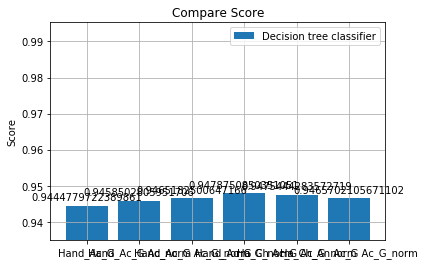

In [47]:
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

labels = EXPERIMEN_RESULT_MAP.keys()

x = np.arange(len(labels))  # the label locations

y_values= []
for res_name in EXPERIMEN_RESULT_MAP:
    y_values.append(EXPERIMEN_RESULT_MAP[res_name])

width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x, y_values, label='Decision tree classifier')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylim(ymin=0.935, ymax=)
ax.set_ylabel('Score')
ax.set_title('Compare Score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='best')
plt.grid(True)

autolabel(rects1, ax)